In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Palatino"
})

#  CEvNS rate

In this notebook I will work out how to calculate the CEvNS rate (initially in xenon, following Jay's code), before writing it into a single script

I will start by just taking one of the fluxes calculated from the spectrum generator, but eventually it might be more useful to just define a spectrum function based on that code

The rate calculation takes the following form:
* Integrate over Enu from Enu_min to 8 MeV, using:
* - Enu_min(E_R, isotope properties)
* Integrand multiplies the:
* - flux (fn of Enu)
* - isotope abundance (of Xe)
* - CEvNS rate
* Overall normalisation factor uses the:
* - flux normalisation (fn of distance from reactor)
* - mass of xenon

I will also follow Jay's practice in being consistent with units by making everything in terms of GeV

## Constants

In [4]:
GeV = 1
MeV = 1e-3*GeV
keV = 1e-6*GeV
eV = 1e-9*GeV
hbarc = 0.19732698 # GeV fm
speed_of_light = 2.997925e8 # m/s
Gf = 1.166378e-5/GeV**2
electron_charge = 1.60217663e-19 # coulombs
amu = 0.931494

METER = 1e15/hbarc
CENTIMETER = 1e-2*METER
SECOND = speed_of_light*METER
YEAR = 60*60*24*365.25*SECOND
JOULE = eV/electron_charge
GIGAWATT = 1e9*JOULE/SECOND
KILOGRAM = speed_of_light**2*JOULE
KILOGRAMDAY = KILOGRAM*(60*60*24*SECOND)
CM2S = CENTIMETER**2*SECOND

In [5]:
xe124 = {"Z": 54, "A": 124, "abundance": 0.00095, "mass": 123.906*amu}
xe126 = {"Z": 54, "A": 126, "abundance": 0.00089, "mass": 125.904*amu}
xe128 = {"Z": 54, "A": 128, "abundance": 0.0191, "mass": 127.904*amu}
xe129 = {"Z": 54, "A": 129, "abundance": 0.26401, "mass": 128.905*amu}
xe130 = {"Z": 54, "A": 130, "abundance": 0.04071, "mass": 129.904*amu}
xe131 = {"Z": 54, "A": 131, "abundance": 0.21232, "mass": 130.905*amu}
xe132 = {"Z": 54, "A": 132, "abundance": 0.26909, "mass": 131.904*amu}
xe134 = {"Z": 54, "A": 134, "abundance": 0.10436, "mass": 133.905*amu}
xe136 = {"Z": 54, "A": 136, "abundance": 0.08857, "mass": 135.907*amu}
isotopesXe = [xe124, xe126, xe128, xe129, xe130, xe131, xe132, xe134, xe136]
mXe = sum([iso["abundance"]*iso["mass"] for iso in isotopesXe])


si28 = {"Z": 14, "A": 28, "abundance": 0.92223, "mass": 27.977*amu}
si29 = {"Z": 14, "A": 29, "abundance": 0.04685, "mass": 28.977*amu}
si30 = {"Z": 14, "A": 30, "abundance": 0.03092, "mass": 29.974*amu}
isotopesSi = [si28, si29, si30]
mSi = sum([iso["abundance"]*iso["mass"] for iso in isotopesSi])

ge70 = {"Z": 32, "A": 70, "abundance": 0.2052, "mass": 69.924*amu}
ge72 = {"Z": 32, "A": 72, "abundance": 0.2745, "mass": 71.922*amu}
ge73 = {"Z": 32, "A": 73, "abundance": 0.0776, "mass": 72.923*amu}
ge74 = {"Z": 32, "A": 74, "abundance": 0.3652, "mass": 73.921*amu}
ge76 = {"Z": 32, "A": 76, "abundance": 0.0775, "mass": 75.921*amu}
isotopesGe = [ge70, ge72, ge73, ge74, ge76]
mGe = sum([iso["abundance"]*iso["mass"] for iso in isotopesGe])

ISOTOPES = {"Xe": isotopesXe, "Si": isotopesSi, "Ge": isotopesGe}

def mTarget(element):
    return sum([iso["abundance"]*iso["mass"] for iso in ISOTOPES[element]])


In [6]:
Qp = 0.0747
Qn = -1.0235

energy_per_fission_i = np.array([201.92, 205.52, 209.99, 213.60])*MeV

## Kinematics

In [7]:
def Enu_min(ER, mT):
    return (ER*mT/2)**0.5

def ER_max(Enu, mT):
    return 2*Enu**2/(mT + 2*Enu)

## CEvNS cross section

In [9]:
def Fhelm(q, A):
    s = 0.9
    r = ( (1.23*A**(1/3) - 0.6)**2 + (7/3)*np.pi**2*0.52**2 - 5*s**2 )**0.5
    return 3 * ( np.sin(q*r/hbarc) - (q*r/hbarc)*np.cos(q*r/hbarc) ) / ( q*r/hbarc )**3 * np.exp( -1*(q*s/hbarc)**2/2 )

def dsigma_dER(ER, Enu, isotope):
    mT = isotope["mass"]
    Z = isotope["Z"]
    A = isotope["A"]


    prefactor = (Gf**2 * isotope["mass"]) / (4*np.pi)
    kinematic_factor = 1 - (ER/Enu) - (ER*mT)/(2*Enu**2)
    weak_charge = Z*Qp + (A-Z)*Qn
    q = (2*mT*ER)**0.5

    return prefactor * kinematic_factor * weak_charge**2 * Fhelm(q, A)

## Fluxes

### [NEW] Calculate fluxes from the individual isotope spectra for a given set of reactor properties

In [10]:
def get_spectrum(filename):
    energies = []
    fluxes = []

    for line in open(filename):
        if not line.startswith("#"):
            line=line.strip("\n")
            lineParts=line.split(",")
            energies.append(float(lineParts[0]))
            fluxes.append(float(lineParts[1]))
    
    return (np.array(energies)*MeV, np.array(fluxes)/MeV)

In [11]:
FLUX_ENU_MIN = 12.5*keV
FLUX_ENU_MAX = 12.5*MeV - 12.5*keV

In [12]:
fissile_isotopes_txtfile_format = ['u235', 'u238', 'pu239', 'pu241']
spectrum_source = 'bestiole'

fission_spectra_data = []
fission_spectra = []

for fi in fissile_isotopes_txtfile_format:
    spec = get_spectrum(f"fluxData/{spectrum_source}_{fi}.txt")
    fission_spectra_data.append(spec)

    fission_spectra.append(CubicSpline(*spec, extrapolate=False))

/home/student.unimelb.edu.au/rittera/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


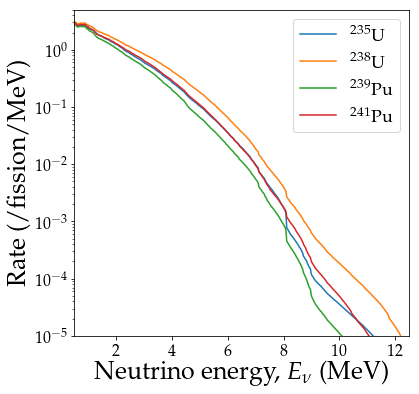

In [35]:
fig, ax = plt.subplots(figsize=(6,6))

for fi, spec_data in zip(fissile_isotopes_txtfile_format, fission_spectra_data):
    isotope_str = '$^{' + f'{fi[-3:]}' + '}$' + fi[0].upper() + fi[1:-3]
    ax.plot(spec_data[0]/MeV, spec_data[1]*MeV, label=isotope_str)

ax.legend(fontsize=18)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0.5, 12.5)
ax.set_ylim(1e-5, 5e0)
ax.tick_params(labelsize=16)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/fission/MeV)", fontsize=25)

fig.savefig('./figures/fissile_isotope_spectra.pdf', bbox_inches='tight')

In [14]:
def reactor_flux(Enu, fuel_fractions, thermal_power):
    norm_fuel_fractions = np.array(fuel_fractions)/sum(fuel_fractions)

    mean_energy_per_fission = sum(norm_fuel_fractions*energy_per_fission_i)

    return (thermal_power/mean_energy_per_fission)*sum([fi*spec(Enu) for fi, spec in zip (norm_fuel_fractions, fission_spectra)])

In [15]:
TRIGA_flux = lambda Enu: reactor_flux(Enu, [.967, .013, .02, 0], 0.001*GIGAWATT)
Kaixuan_flux = lambda Enu: reactor_flux(Enu, [.26, .076, .51, .148], 1*GIGAWATT)
HFIR_flux = lambda Enu: reactor_flux(Enu, [1, 0, 0, 0], 0.085*GIGAWATT)

I can also just list the properties of each reactor for use in later code

In [16]:
TRIGA_properties = ([0.967, 0.013, 0.02, 0], 0.001*GIGAWATT)
Kaixuan_properties = ([.26, .076, .51, .148], 1*GIGAWATT)
HFIR_properties =  ([1, 0, 0, 0], 0.085*GIGAWATT)

### [OLD] Get the fluxes generated by reactorNuSpectrumGenerator code

This code generates interpolations functions for the fluxes the are generated by the reactorNuSpectrumGenerator code

In [13]:
def get_spectrum_OLD(filename):
    energies = []
    fluxes = []

    for line in open(filename):
        if not line.startswith("#"):
            line=line.strip("\n")
            lineParts=line.split(",")
            energies.append(float(lineParts[0]))
            fluxes.append(float(lineParts[1]))
    
    return (np.array(energies)*MeV, np.array(fluxes)/SECOND/MeV) # this is to put it in units in terms of GeV

In [14]:
TRIGA_flux_data_OLD = get_spectrum_OLD('spectra/TRIGA_flux.text')
Kaixuan_flux_data_OLD = get_spectrum_OLD('spectra/Kaixuan_flux.text')
HFIR_flux_data_OLD = get_spectrum_OLD('spectra/HFIR_flux.text')

In [15]:
TRIGA_flux_OLD = CubicSpline(*TRIGA_flux_data_OLD, extrapolate=False)
Kaixuan_flux_OLD = CubicSpline(*Kaixuan_flux_data_OLD, extrapolate=False)
HFIR_flux_OLD = CubicSpline(*HFIR_flux_data_OLD, extrapolate=False)

Text(0,0.5,'Rate (Hayes)/ Rate (BESTIOLE)')

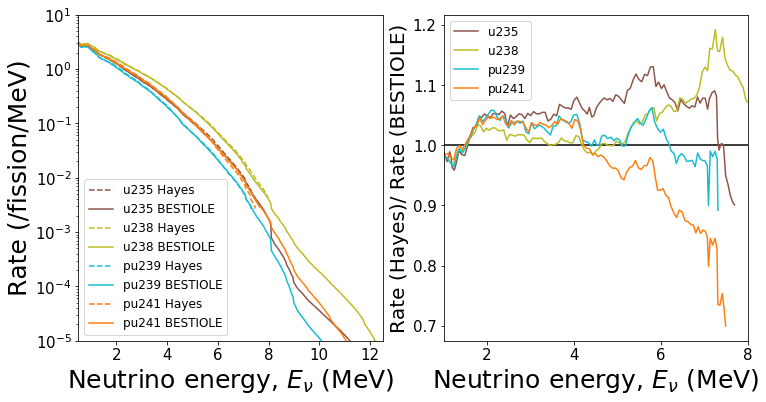

In [74]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

for fi in fissile_isotopes_txtfile_format:
    hayes_spec_data = get_spectrum(f"fluxData/hayes_{fi}.txt")
    bestiole_spec_data = get_spectrum(f"fluxData/bestiole_{fi}.txt")

    axes[0].plot(hayes_spec_data[0]/MeV, hayes_spec_data[1]*MeV, f'C{fi[-1]}--', label=f'{fi} Hayes')
    axes[0].plot(bestiole_spec_data[0]/MeV, bestiole_spec_data[1]*MeV, f'C{fi[-1]}', label=f'{fi} BESTIOLE')

    hayes_spline = CubicSpline(*hayes_spec_data, extrapolate=False)
    bestiole_spline = CubicSpline(*bestiole_spec_data, extrapolate=False)

    axes[1].plot(hayes_spline.x/MeV, hayes_spline(hayes_spline.x)/bestiole_spline(hayes_spline.x), f'C{fi[-1]}', label=fi)

# AXES[0] OPTIONS

axes[0].legend(fontsize=12)

axes[0].set_yscale('log')
# axes[0].set_xscale('log')
axes[0].set_xlim(0.5, 12.5)
axes[0].set_ylim(1e-5, 1e1)
axes[0].tick_params(labelsize=15)

axes[0].set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
axes[0].set_ylabel("Rate (/fission/MeV)", fontsize=25)

# AXES[1] OPTIONS

axes[1].hlines(1, 1, 8)

axes[1].legend(fontsize=12)

axes[1].set_xlim(1,8)
axes[1].tick_params(labelsize=15)

axes[1].set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
axes[1].set_ylabel("Rate (Hayes)/ Rate (BESTIOLE)", fontsize=20)



## CEvNS rate in xenon

In [20]:
def flux_norm(L):
    return 1/(4*np.pi*L**2)

def dR_dER_Xe(ER, flux, L):

    try:
        flux_Enu_min, flux_Enu_max = flux.x[0], 8*MeV #flux.x[-1] #THIS ONLY WORKS IF THE FLUX IS AN INTERPOLATING FUNCTION (CUBICSPLINE)
    except:
        flux_Enu_min, flux_Enu_max = FLUX_ENU_MIN, FLUX_ENU_MAX

    # flux_Enu_min, flux_Enu_max = 1*MeV, 9*MeV

    def integrand(Enu, isotope):
        return flux(Enu) * isotope["abundance"] * dsigma_dER(ER, Enu, isotope)

    def unnormalised_rate_per_isotope(isotope):

        min_endpoint = min( max( Enu_min(ER, isotope["mass"]), flux_Enu_min ), flux_Enu_max )
        max_endpoint = flux_Enu_max
        
        integral = quad(integrand, min_endpoint, max_endpoint, args=(isotope))
        return integral[0]

    return (flux_norm(L)/mXe)*sum([unnormalised_rate_per_isotope(isotope) for isotope in isotopesXe])

Example rates calculations

In [136]:
ER_array = np.linspace(0.02, 2.5, 50)
TRIGA5m_rate_data = np.array([dR_dER_Xe(ER*keV, TRIGA_flux, 5*METER)*KILOGRAMDAY*keV for ER in ER_array])
HFIR7m_rate_data = np.array([dR_dER_Xe(ER*keV, HFIR_flux, 7*METER)*KILOGRAMDAY*keV for ER in ER_array])
Kaixuan25m_rate_data = np.array([dR_dER_Xe(ER*keV, Kaixuan_flux, 25*METER)*KILOGRAMDAY*keV for ER in ER_array])

TRIGA5m_rate_data_OLD = np.array([dR_dER_Xe(ER*keV, TRIGA_flux_OLD, 5*METER)*KILOGRAMDAY*keV for ER in ER_array])
HFIR7m_rate_data_OLD = np.array([dR_dER_Xe(ER*keV, HFIR_flux_OLD, 7*METER)*KILOGRAMDAY*keV for ER in ER_array])
Kaixuan25m_rate_data_OLD = np.array([dR_dER_Xe(ER*keV, Kaixuan_flux_OLD, 25*METER)*KILOGRAMDAY*keV for ER in ER_array])


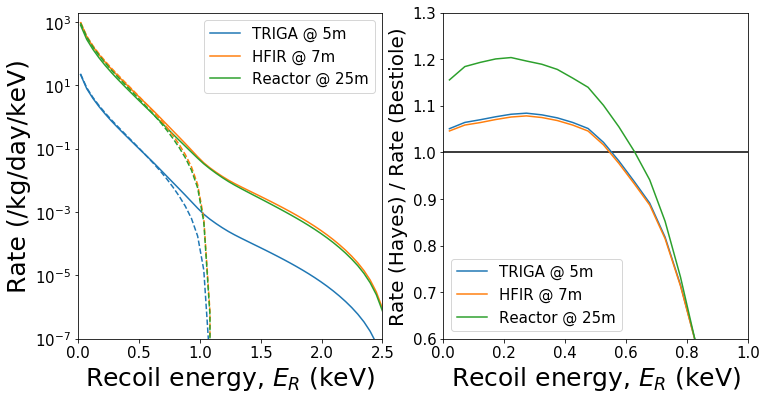

In [137]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

axes[0].plot(ER_array, TRIGA5m_rate_data, 'C0', label="TRIGA @ 5m")
axes[0].plot(ER_array, HFIR7m_rate_data, 'C1', label="HFIR @ 7m")
axes[0].plot(ER_array, Kaixuan25m_rate_data, 'C2', label="Reactor @ 25m")

axes[0].plot(ER_array, TRIGA5m_rate_data_OLD, 'C0--')
axes[0].plot(ER_array, HFIR7m_rate_data_OLD, 'C1--')
axes[0].plot(ER_array, Kaixuan25m_rate_data_OLD, 'C2--')

axes[0].set_xlabel("Recoil energy, $E_R$ (keV)", fontsize=25)
axes[0].set_ylabel("Rate (/kg/day/keV)", fontsize=25)

axes[0].legend(fontsize=15)

axes[0].set_yscale('log')
axes[0].set_xlim(0, 2.5)
axes[0].set_ylim(1e-7, 2e3)
axes[0].tick_params(labelsize=15)
axes[0].set_xticks([0,.5,1,1.5,2,2.5])

axes[1].plot(ER_array, TRIGA5m_rate_data_OLD/TRIGA5m_rate_data, 'C0', label="TRIGA @ 5m")
axes[1].plot(ER_array, HFIR7m_rate_data_OLD/HFIR7m_rate_data, "C1", label="HFIR @ 7m")
axes[1].plot(ER_array, Kaixuan25m_rate_data_OLD/Kaixuan25m_rate_data, "C2", label="Reactor @ 25m")

axes[1].set_xlabel("Recoil energy, $E_R$ (keV)", fontsize=25)
axes[1].set_ylabel("Rate (Hayes) / Rate (Bestiole)", fontsize=20)

axes[1].hlines(1, 0, 2)

axes[1].legend(fontsize=15)

axes[1].set_xlim(0, 1)
axes[1].set_ylim(0.6, 1.3)
axes[1].tick_params(labelsize=15)


In [138]:
def total_CEvNS_rate_Xe(threshold, flux, L):
    try:
        flux_Enu_max = flux.x[-1] #THIS ONLY WORKS IF THE FLUX IS AN INTERPOLATING FUNCTION (CUBICSPLINE)
    except:
        flux_Enu_max = FLUX_ENU_MAX

    return quad(dR_dER_Xe, threshold, ER_max(flux_Enu_max, mXe), args=(flux, L))[0]

In [139]:
print("Events/kg/day at HFIR @ 7m with different thresholds (BESTIOLE fluxes):")
print(f"0.1 keV: {total_CEvNS_rate_Xe(0.1*keV, HFIR_flux, 7*METER)*KILOGRAMDAY:.3e}")
print(f"0.2 keV: {total_CEvNS_rate_Xe(0.2*keV, HFIR_flux, 7*METER)*KILOGRAMDAY:.3e}")
print(f"0.5 keV: {total_CEvNS_rate_Xe(0.5*keV, HFIR_flux, 7*METER)*KILOGRAMDAY:.3e}")
print(f"1 keV: {total_CEvNS_rate_Xe(1*keV, HFIR_flux, 7*METER)*KILOGRAMDAY:.3e}")

print("Events/kg/day at HFIR @ 7m with different thresholds (Hayes fluxes):")
print(f"0.1 keV: {total_CEvNS_rate_Xe(0.1*keV, HFIR_flux_OLD, 7*METER)*KILOGRAMDAY:.3e}")
print(f"0.2 keV: {total_CEvNS_rate_Xe(0.2*keV, HFIR_flux_OLD, 7*METER)*KILOGRAMDAY:.3e}")
print(f"0.5 keV: {total_CEvNS_rate_Xe(0.5*keV, HFIR_flux_OLD, 7*METER)*KILOGRAMDAY:.3e}")
print(f"1 keV: {total_CEvNS_rate_Xe(1*keV, HFIR_flux_OLD, 7*METER)*KILOGRAMDAY:.3e}")

Events/kg/day at HFIR @ 7m with different thresholds (BESTIOLE fluxes):
0.1 keV: 2.008e+01
0.2 keV: 7.210e+00
0.5 keV: 5.057e-01
1 keV: 7.555e-03
Events/kg/day at HFIR @ 7m with different thresholds (Hayes fluxes):
0.1 keV: 2.140e+01
0.2 keV: 7.650e+00
0.5 keV: 4.620e-01
1 keV: 6.940e-05


## CEvNS rate in general detector materials

The only difference one needs to make for different detector materials is the list of isotopes and their properties. I can incorporate this easily within a general rate function

I can also choose to input the flux as a function for a particular reactor, or just by inputting a list of reactor properties

In [17]:
def dR_dER(ER, detector_material, flux, L):

    try:
        fuel_fractions, thermal_power = flux
        flux = lambda Enu: reactor_flux(Enu, fuel_fractions, thermal_power)
    except:
        pass

    flux_Enu_min, flux_Enu_max = FLUX_ENU_MIN, FLUX_ENU_MAX # I am now writing this to only be used with the BESTIOLE flux

    mT = mTarget(detector_material)

    def integrand(Enu, isotope):
        return flux(Enu) * isotope["abundance"] * dsigma_dER(ER, Enu, isotope)

    def unnormalised_rate_per_isotope(isotope):

        min_endpoint = min( max( Enu_min(ER, isotope["mass"]), flux_Enu_min ), flux_Enu_max )
        max_endpoint = flux_Enu_max
        
        integral = quad(integrand, min_endpoint, max_endpoint, args=(isotope))
        return integral[0]

    return (flux_norm(L)/mT)*sum([unnormalised_rate_per_isotope(isotope) for isotope in ISOTOPES[detector_material]])

In [18]:
def total_CEvNS_rate(threshold, detector_material, flux, L):
    try:
        fuel_fractions, thermal_power = flux
        flux = lambda Enu: reactor_flux(Enu, fuel_fractions, thermal_power)
    except:
        pass
    
    flux_Enu_max = FLUX_ENU_MAX

    mT = mTarget(detector_material)

    return quad(dR_dER, threshold, ER_max(flux_Enu_max, mT), args=(detector_material, flux, L))[0]

/home/student.unimelb.edu.au/rittera/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


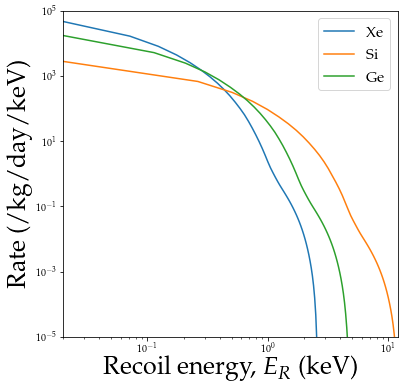

In [37]:
fig, ax = plt.subplots(figsize=(6,6))

for i, element in enumerate(["Xe", "Si", "Ge"]):
    ERmax = ER_max(FLUX_ENU_MAX, mTarget(element))
    ER_array = np.linspace(0.02, ERmax/keV, 50)
    rate_data = np.array([dR_dER(ER*keV, element, HFIR_flux, 1*METER)*KILOGRAMDAY*keV for ER in ER_array])

    ax.plot(ER_array, rate_data, f'C{i}', label=element)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2e-2, 12)
ax.set_ylim(1e-5, 1e5)
ax.set_xlabel("Recoil energy, $E_R$ (keV)", fontsize=25)
ax.set_ylabel("Rate (/kg/day/keV)", fontsize=25)
ax.legend(fontsize=15)

Recreating Table II from Bowen and Huber (2005.10907)

In [22]:
elements = ["Si", "Ge", "Xe"]
thresholds = np.array([0, 0.01, 0.1, 1])*keV

print("Threshold [keV] | " + " | ".join(elements))
for threshold in thresholds:
    CEvNS_events = []
    for element in elements:
        CEvNS_events.append(f'{total_CEvNS_rate(threshold, element, ([1, 0, 0, 0], 0.1*GIGAWATT), 10*METER)*KILOGRAM*YEAR:.0f}')
    print(f'{threshold/keV}           | ' + " | ".join(CEvNS_events))

    

Threshold [keV] | Si | Ge | Xe
0.0           | 2710 | 9016 | 18244
0.01           | 2553 | 7822 | 14417
0.1           | 1748 | 3565 | 4229
1.0           | 198 | 33 | 2


## Checking the effect of different endpoints

In [49]:
def dR_dER_Xe_endpoint(ER, flux, L, endpoint):

    flux_Enu_min, flux_Enu_max = flux.x[0], endpoint
    
    def integrand(Enu, isotope):
        return flux(Enu) * isotope["abundance"] * dsigma_dER(ER, Enu, isotope)

    def unnormalised_rate_per_isotope(isotope):

        min_endpoint = min( max( Enu_min(ER, isotope["mass"]), flux_Enu_min ), flux_Enu_max )
        max_endpoint = flux_Enu_max
        
        integral = quad(integrand, min_endpoint, max_endpoint, args=(isotope))
        return integral[0]

    return (flux_norm(L)/mXe)*sum([unnormalised_rate_per_isotope(isotope) for isotope in isotopesXe])

def total_CEvNS_rate_Xe_endpoint(threshold, flux, L, endpoint):
    return quad(dR_dER_Xe_endpoint, threshold, ER_max(endpoint, mXe), args=(flux, L, endpoint))[0]

In [31]:
ER_array = np.linspace(0.02, 2, 50)
HFIR7m_rate_data_8MeV = [dR_dER_Xe_endpoint(ER*keV, HFIR_flux, 7*METER, 8*MeV)*KILOGRAMDAY*keV for ER in ER_array]
HFIR7m_rate_data_9MeV = [dR_dER_Xe_endpoint(ER*keV, HFIR_flux, 7*METER, 9*MeV)*KILOGRAMDAY*keV for ER in ER_array]

In [41]:
1*MeV/mXe

8.176705691544718e-06

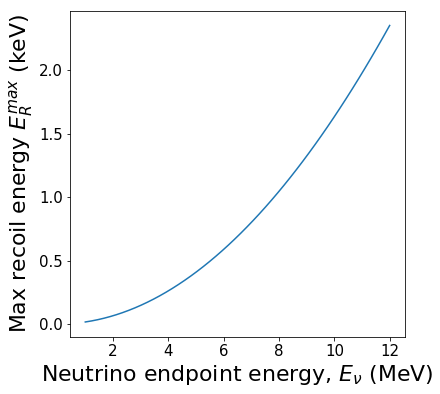

In [47]:
fig, ax = plt.subplots(figsize=(6,6))

Enu_array = np.linspace(1,12,50)

ax.plot(Enu_array, ER_max(np.linspace(1,12,50)*MeV, mXe)/keV)

ax.set_xlabel(r"Neutrino endpoint energy, $E_\nu$ (MeV)", fontsize=22)
ax.set_ylabel("Max recoil energy $E_R^{max}$ (keV)", fontsize=22)

ax.tick_params(labelsize=15)

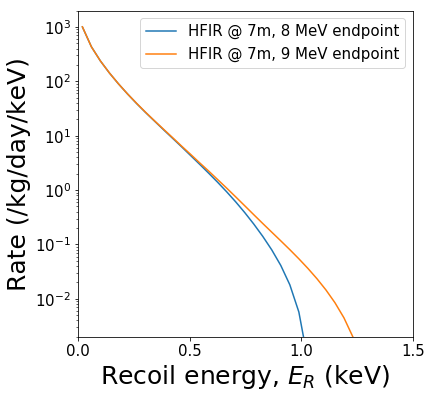

In [32]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(ER_array, HFIR7m_rate_data_8MeV, label="HFIR @ 7m, 8 MeV endpoint")
ax.plot(ER_array, HFIR7m_rate_data_9MeV, label="HFIR @ 7m, 9 MeV endpoint")

ax.set_xlabel("Recoil energy, $E_R$ (keV)", fontsize=25)
ax.set_ylabel("Rate (/kg/day/keV)", fontsize=25)

ax.legend(fontsize=15)

ax.set_yscale('log')
ax.set_xlim(0, 1.5)
ax.set_ylim(2e-3, 2e3)
ax.tick_params(labelsize=15)
ax.set_xticks([0,.5,1,1.5])

In [51]:
print("Events/kg/day at HFIR @ 7m with different thresholds and endpoints:")
print(f"threshold 0.1 keV, endpoint 8 MeV: {total_CEvNS_rate_Xe_endpoint(0.1*keV, HFIR_flux, 7*METER, 8*MeV)*KILOGRAMDAY:.3e}")
print(f"threshold 0.1 keV, endpoint 9 MeV: {total_CEvNS_rate_Xe_endpoint(0.1*keV, HFIR_flux, 7*METER, 9*MeV)*KILOGRAMDAY:.3e}")
print(f"threshold 0.5 keV, endpoint 8 MeV: {total_CEvNS_rate_Xe_endpoint(0.5*keV, HFIR_flux, 7*METER, 8*MeV)*KILOGRAMDAY:.3e}")
print(f"threshold 0.5 keV, endpoint 9 MeV: {total_CEvNS_rate_Xe_endpoint(0.5*keV, HFIR_flux, 7*METER, 9*MeV)*KILOGRAMDAY:.3e}")

Events/kg/day at HFIR @ 7m with different thresholds and endpoints:
threshold 0.1 keV, endpoint 8 MeV: 2.138e+01
threshold 0.1 keV, endpoint 9 MeV: 2.156e+01
threshold 0.5 keV, endpoint 8 MeV: 4.620e-01
threshold 0.5 keV, endpoint 9 MeV: 5.304e-01


In [55]:
thresholds = np.linspace(0.1, 1, 25)
factor_endpoint_gain = [total_CEvNS_rate_Xe_endpoint(threshold*keV, HFIR_flux, 1*METER, 9*MeV)/total_CEvNS_rate_Xe_endpoint(threshold*keV, HFIR_flux, 1*METER, 8*MeV) for threshold in thresholds]


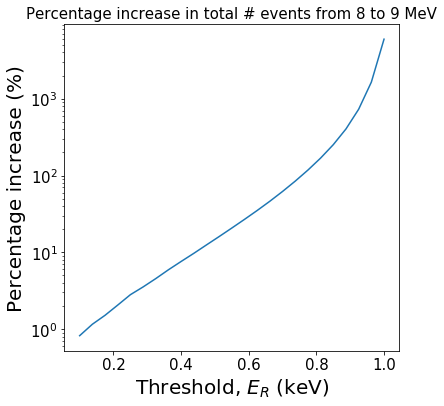

In [66]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(thresholds, 100*(factor_endpoint_gain - np.ones(25)))

ax.set_xlabel(r"Threshold, $E_R$ (keV)", fontsize=20)
ax.set_ylabel("Percentage increase (%)", fontsize=20)
ax.set_title("Percentage increase in total # events from 8 to 9 MeV", fontsize=15)

ax.tick_params(labelsize=15)

ax.set_yscale('log')